# Notebook Instructions
<i>You can run the notebook document sequentially (one cell a time) by pressing <b> shift + enter</b>. While a cell is running, a [*] will display on the left. When it has been run, a number will display indicating the order in which it was run in the notebook [8].</i>

<i>Enter edit mode by pressing <b>`Enter`</b> or using the mouse to click on a cell's editor area. Edit mode is indicated by a green cell border and a prompt showing in the editor area.</i>

# Calendar Spread Payoff

A calendar spread strategy profits from the time decay and/or increase in the implied volatility of the options. In this notebook, we will create a payoff graph of the calendar spread at the expiry of the front-month option.

## Import the libraries

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# To plot
import matplotlib.pyplot as plt
import seaborn

# BS model
import mibian

## Setup
Calendar spread involves options of the same underlying asset, the same strike price but with different expiration dates. 

- Sell a call (or put) with near-term expiration — <font color=blue>“front-month”</font>
- Buy a call (or put) with long-term expiration — <font color=blue>“back-month”</font>

## Calendar spread on Nifty
We will set up the calendar spread on Nifty as shown below.

- Sell 10400 strike call @ INR 50.50 expiring on 28 November 2017 — <font color=blue>“front-month”</font>
- Buy 10400 strike call @ INR 148.50 expiring on 30 December 2017 — <font color=blue>“back-month”</font>

In [2]:
# Nifty futures price 
nifty_nov_fut = 10350.00
nifty_dec_fut = 10387.00

strike_price = 10400
nov_call_price = 50.50
dec_call_price = 148.50
setup_cost = dec_call_price - nov_call_price

# Today's date is 21 November 2017. Therefore, days to November expiry is 7 days and days to December expiry is 34 days.
days_to_expiry_nov_call = 7
days_to_expiry_dec_call = 34

# Range of values for Nifty
sT = np.arange(0.92*nifty_nov_fut,1.1*nifty_nov_fut,1) 

# Interest rate for input to Black-Scholes model
interest_rate = 0.0

## Implied volatility

We will calculate the implied volatilities for the front-month and back-month call option using Black-Scholes model. This implied volatility will be later used as input to Black-Scholes model to calculate the call price for diiferent values of Nifty.

In [3]:
# Front-month IV
nov_call_iv = mibian.BS([nifty_nov_fut, strike_price, interest_rate, days_to_expiry_nov_call], 
                        callPrice=nov_call_price).impliedVolatility
print("Front Month IV %.2f" % nov_call_iv,"%")

# Back-month IV
dec_call_iv = mibian.BS([nifty_dec_fut, strike_price, interest_rate, days_to_expiry_dec_call], 
                        callPrice=dec_call_price).impliedVolatility
print("Back Month IV %.2f" % dec_call_iv,"%")

Front Month IV 12.70 %
Back Month IV 12.25 %


## Calculating the call price for front and back month option
Since there are two expiration dates for the options in the calendar spread, Black-Scholes pricing model is used to guesstimate the price of the front-month and back-month 10400 strike call at the front-month call expiry. You may change the days to expiry below to see how payoff changes.

Note: We have assumed that all other things such as implied volatility and interest rates remain constant.

In [4]:
# Changing days to expiry to a day before the front-month expiry
days_to_expiry_nov_call = 0.001
days_to_expiry_dec_call = 29 - days_to_expiry_nov_call

df = pd.DataFrame()
df['nifty_price'] = sT
df['nov_call_price'] = np.nan
df['dec_call_price'] = np.nan

# Calculating call price for different possible values of Nifty
for i in range(0,len(df)):
    df.loc[i,'nov_call_price'] = mibian.BS([df.iloc[i]['nifty_price'], strike_price, interest_rate, days_to_expiry_nov_call], 
                                           volatility=nov_call_iv).callPrice
    
    # Since interest rate is considered 0%, 35 is added to the nifty price to get the Nifty December futures price. 
    df.loc[i,'dec_call_price'] = mibian.BS([df.iloc[i]['nifty_price']+35, strike_price, interest_rate, days_to_expiry_dec_call], 
                                           volatility=dec_call_iv).callPrice
df.head()

,nifty_price,nov_call_price,dec_call_price
0,9522.0,0.0,0.806387
1,9523.0,0.0,0.813929
2,9524.0,0.0,0.821534
3,9525.0,0.0,0.829203
4,9526.0,0.0,0.836937


## Payoff

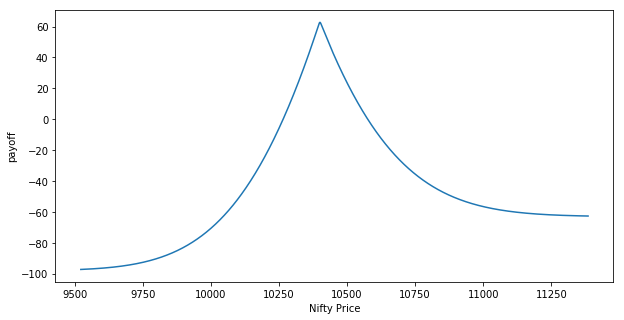

In [5]:
df['payoff'] = df.dec_call_price - df.nov_call_price - setup_cost
plt.figure(figsize=(10,5))
plt.ylabel("payoff")
plt.xlabel("Nifty Price")
plt.plot(sT,df.payoff)
plt.show()

The key takeaways from the graphs are - 

1. The maximum profit is realized when the nifty price on expiry of front-month is at a strike price of INR 10400 
2. The profit decreases as we move away from the strike price of INR 10400 in either direction. 
3. The maximum loss is realized as the option moves deep ITM or deep OTM.